In [65]:
## Imports
import pandas as pd
import tensorflow as tf
import numpy as np

!pip install -q efficientnet
import efficientnet.tfkeras as efn

from tqdm import tqdm

import math
from math import ceil, floor, log
import matplotlib.pyplot as plt

In [45]:
# Setting up constants
SEED = 5
N_epochs = 50

In [18]:
#Load data and cut off bad quality ones
df = pd.read_csv('labels.csv')
df = df.query('photo_quality == 1')
df['label'].value_counts()

bee       2469
insect    2439
wasp      2127
Name: label, dtype: int64

In [19]:
#Set up models to be run
MODELS = {
          'ResNet50':[tf.keras.applications.ResNet50,32,300],
          'DenseNet121':[tf.keras.applications.DenseNet121,32,300],
          'EfficientNetB6':[efn.EfficientNetB6,8,300]
         }

In [20]:
# Replace \ with / to make the path work
for idx in tqdm(df.index):    
    df.loc[idx,'path']=df.loc[idx,'path'].replace('\\', '/') 

100%|██████████| 7035/7035 [00:04<00:00, 1688.36it/s]


In [32]:
#List of columns we are interested in
labels_cols = ['is_bee', 'is_wasp', 'is_otherinsect', 'is_other']

#Split data into training, validation, and test data
df_train = df.loc[(df.is_validation == 0) & (df.is_final_validation == 0)]
df_valid = df.loc[(df.is_validation == 1)]
df_test = df.loc[(df.is_final_validation == 1)]

In [33]:
y_train = df_train.loc[:,['id']+labels_cols]
y_train.set_index('id', inplace = True)
y_valid = df_valid.loc[:,['id']+labels_cols]
y_valid.set_index('id', inplace = True)
y_test = df_test.loc[:,['id']+labels_cols]
y_test.set_index('id', inplace = True)

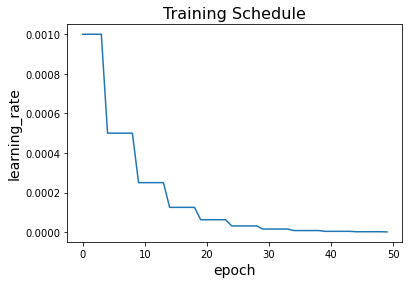

In [48]:

def get_lr_callback(plot=False):
    start_lr = 0.001
    def step_decay(epoch):
        drop = 0.5
        epochs_drop = 5.0
        lr = start_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
        return lr
    
    lr_callback = tf.keras.callbacks.LearningRateScheduler(step_decay)
    if plot == True:
        rng = [i for i in range(N_epochs)]
        y = [step_decay(x) for x in rng]
        plt.plot(rng, y)
        plt.xlabel('epoch', size=14)
        plt.ylabel('learning_rate', size=14)
        plt.title('Training Schedule', size=16)
        plt.show()
        
    return lr_callback


es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               monitor='val_loss',
                                               verbose=1, 
                                               restore_best_weights=True)
lr = get_lr_callback(plot=True)



In [62]:
#Værdier til instantiering af ImageDataGenerator er taget fra eksemplet fundet under afsnittet 'Set up the Flowers dataset' på https://www.tensorflow.org/hub/tutorials/tf2_image_retraining

def gen_init(BS, IMG_Size):
    #Vi normalisere trænings dataene
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        horizontal_flip=True,
        vertical_flip = True,
        width_shift_range=0.2, height_shift_range=0.2,
        shear_range=0.2, zoom_range=0.2)

    train_generator = train_gen.flow_from_dataframe(dataframe=df_train, 
                                                  x_col="path", y_col=labels_cols, 
                                                  class_mode="raw", 
                                                  target_size=(IMG_Size,IMG_Size), batch_size = BS)

    #Data til validering skal ikke normaliseres, men vi skalerer det til samme opløsning som træningsdataene
    valid_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)    
    
    
    valid_generator = valid_gen.flow_from_dataframe(dataframe=df_valid,
                                                  x_col="path", y_col=labels_cols, 
                                                  class_mode="raw", 
                                                  # class_mode="categorical", 
                                                  target_size=(IMG_Size,IMG_Size), batch_size = BS)

    #Data til test skal heller ikke normaliseres, men vi skalerer det ligeledes  
    test_generator = valid_gen.flow_from_dataframe(dataframe=df_test,
                                                  x_col="path", y_col=labels_cols, 
                                                  class_mode="raw", 
                                                  shuffle = False,
                                                  target_size=(IMG_Size,IMG_Size), batch_size = BS)

    return   train_generator,   valid_generator, test_generator

In [63]:
train_generator, valid_generator, test_generator = gen_init(32,200)

Found 4908 validated image filenames.
Found 1043 validated image filenames.
Found 1084 validated image filenames.


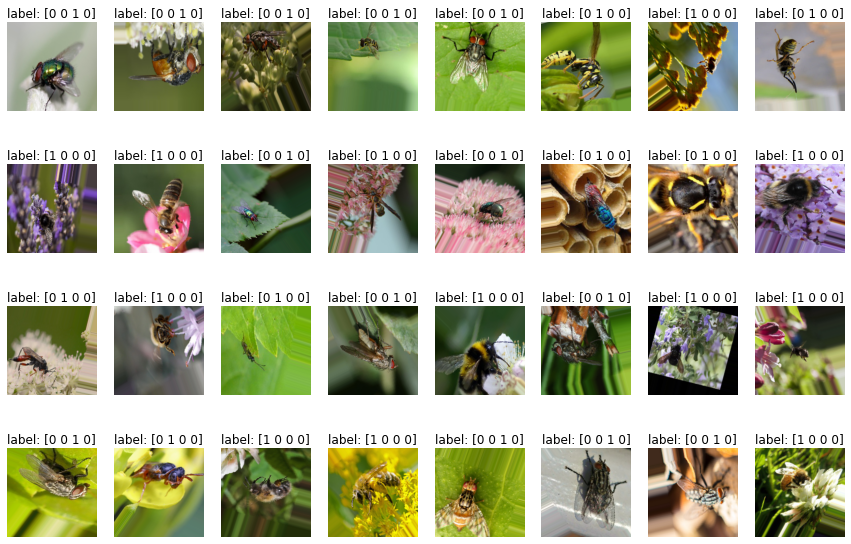

In [67]:
ti, tl = train_generator.next()
imgs = []
for i in range(ti.shape[0]):
    img = np.array(ti[i]*255, dtype = 'int32')
    imgs.append(img)

f, ax = plt.subplots(4, 8, figsize=(15,10))
for i, img in enumerate(imgs):
    ax[i//8, i%8].imshow(img)
    ax[i//8, i%8].axis('off')
    ax[i//8, i%8].set_title('label: %s' % tl[i])
plt.show()